In [1]:
sys.path.append("..")
import utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import warnings
warnings.filterwarnings("ignore")

In [2]:
def get_paths(dir_path = "../results/full_vaccines"):
    paths = os.listdir(dir_path)
    rel_paths = []
    for i in range(len(paths)):
        if not (paths[i] == '.DS_Store'):
            rel_paths.append("results/full_vaccines/" + paths[i])
            print(paths[i].split("_")[2] + " " + paths[i].split("_")[3])
    return rel_paths

## Plot vaccinated distribution for all results

Read results

In [3]:
paths = get_paths()
results = {}
for relative_path in paths:
    results[relative_path] = utils.read_csv(relative_path=relative_path)

infection based
susceptible based
fhi policy
oldest first
contact based
random 2021
Reading results ..
100%|██████████| 500/500 [00:16<00:00, 30.08it/s]
Reading results ..
100%|██████████| 500/500 [00:17<00:00, 28.69it/s]
Reading results ..
100%|██████████| 500/500 [00:22<00:00, 22.37it/s]
Reading results ..
100%|██████████| 500/500 [00:27<00:00, 18.34it/s]
Reading results ..
100%|██████████| 500/500 [00:20<00:00, 24.60it/s]
Reading results ..
100%|██████████| 500/500 [00:17<00:00, 28.74it/s]


infection based
susceptible based
fhi policy
oldest first
contact based
random 2021


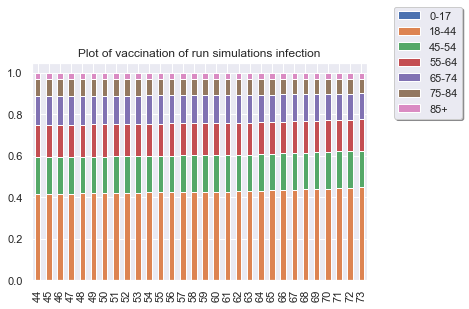

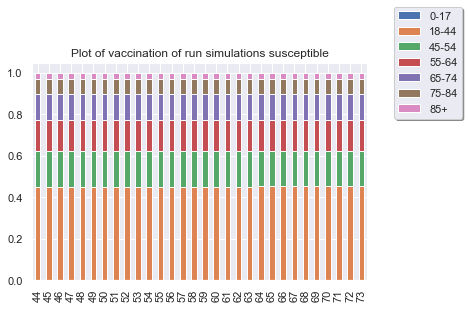

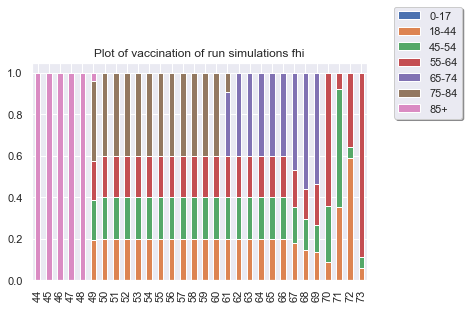

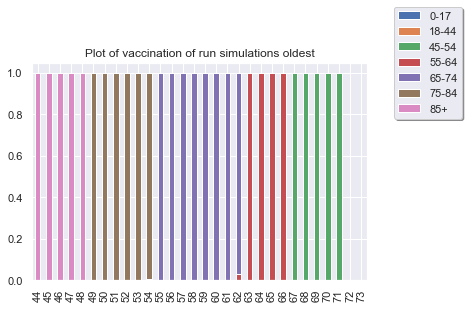

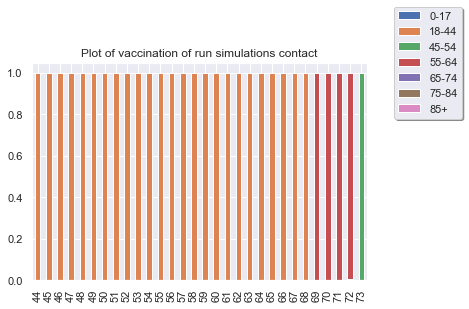

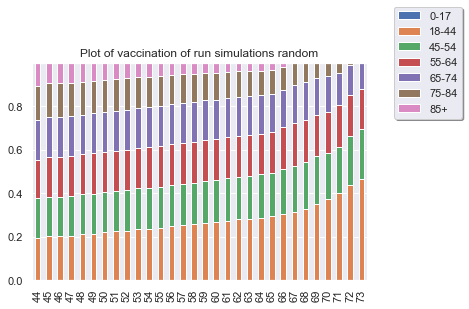

In [4]:
paths = get_paths()
for relative_path in paths:
    age_labels = results[relative_path][0]
    vaccinated_age_groups = results[relative_path][-1]
    vaccinated_age_groups = np.diff(vaccinated_age_groups, axis=1)
    vaccinated = vaccinated_age_groups.mean(axis=0)
    week_cut = np.where(vaccinated > 0)[0][0]
    norm = np.where(np.int64(vaccinated.sum(axis=1, keepdims=True))==0, 1, vaccinated.sum(axis=1, keepdims=True))
    vaccinated[week_cut:].sum(axis=1)
    vaccinated_proportions = np.divide(vaccinated, norm)
    vaccinated_proportions[week_cut:].sum(axis=1)
    vaccinated_cumsum = vaccinated.cumsum(axis=1)
    weeks = np.arange(vaccinated_proportions.shape[0])
    df = pd.DataFrame(columns = age_labels, data=vaccinated_proportions[week_cut:], index=weeks[week_cut:])
    sns.set()
    df.plot(kind='bar', stacked=True)
    plt.title(f"Plot of vaccination of run {relative_path.split('_')[2]} {relative_path.split('_')[3]}")
    plt.legend(loc='right', bbox_to_anchor=(1.3, 1), ncol=1, fancybox=True, shadow=True)
    plt.show()

## Analysis of simulations needed

In [5]:
objective_values = {}
for keys in results.keys():
    objective_values[keys] = np.zeros((500,4)) #element 0: deaths, element 1: infected, element 2: yll, element 3: vaccinated


In [6]:
for key in list(results.keys()):
    print("Finding objective values for ", key)
    result = results[key]
    age_labels = result[0]
    paths = utils.create_named_tuple('paths', 'filepaths.txt')
    config = utils.create_named_tuple('config', paths.config)

    new_deaths_age_groups = result[-2]
    cumulative_deaths = new_deaths_age_groups.cumsum(axis=1)
    cum_deaths = np.zeros((cumulative_deaths.shape[0], cumulative_deaths.shape[2]))
    yll = np.zeros((cumulative_deaths.shape[0]))
    for i in range(cumulative_deaths.shape[0]):
        cum_deaths[i] = cumulative_deaths[i,-1,:]
        yll[i] = utils.calculate_yll(utils.get_expected_yll(config.age_bins, age_labels),  cum_deaths[i]) 
    deaths = np.sum(cum_deaths, axis=1)

    new_infected_age_groups = result[-3]
    cumulative_infected = new_infected_age_groups.cumsum(axis=1)
    infected = np.zeros((cumulative_infected.shape[0]))
    for i in range(cumulative_infected.shape[0]):
        infected[i] = np.sum(cumulative_infected[i,-1,:])

    vaccinated_age_groups = result[-1]
    #cumulative_vaccinated = vaccinated_age_groups.cumsum(axis=1)
    vaccinated = np.zeros((vaccinated_age_groups.shape[0]))
    for i in range(vaccinated_age_groups.shape[0]):
        vaccinated[i] = np.sum(vaccinated_age_groups[i,-1,:])

    
    print(vaccinated)
    objective_values[key][:,0] = deaths
    objective_values[key][:,1] = infected
    objective_values[key][:,2] = yll
    objective_values[key][:,3] = vaccinated

Finding objective values for  results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47
[2454571.99879432 2467458.42727329 2446149.84822009 2502536.68139538
 2466240.766166   2449647.55264633 2476052.74713759 2368870.6093242
 2460405.12207718 2449424.5469242  2469332.27916373 2452932.857852
 2455530.75755237 2482205.91865156 2316969.28456739 2478298.25453592
 2479436.12774015 2442692.82597887 2486550.96472597 2386978.74066436
 2156591.6773606  2464858.28446569 2461779.54619762 2363359.10949106
 2450548.87570534  321681.11124735 2452182.51122435 2446154.38599106
 2427760.93548186 2420466.33842349 2458002.55746938 2465878.831001
 2453632.0454034  2482721.62007486 2472394.53094654 2458390.39286971
 2461177.57102951 2454299.95193065 2433659.5307942  2475364.08104033
 2456714.36278608 2438093.55374137 2462069.15969967 2451514.67108828
 2447391.34131349 2473920.01585965 2462171.14939745 2442276.66484952
 2479364.06270591 2470708.44989782  767996.66788502 2476096.4644738
 2464

In [7]:
def density_plot(values, ax):
    # Draw the density plot
    sns.distplot(values, hist = False, kde = True,
                 kde_kws = {'linewidth': 1},
                 label = key.split('_')[2] + ' ' + key.split('_')[3], ax=ax)

Deaths



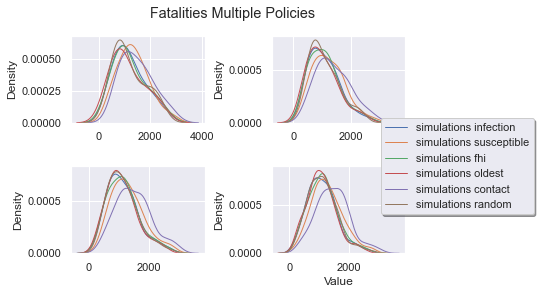

Infected



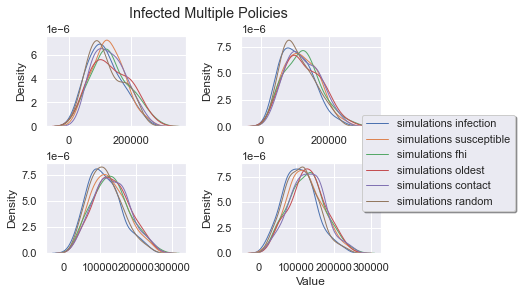

YLL



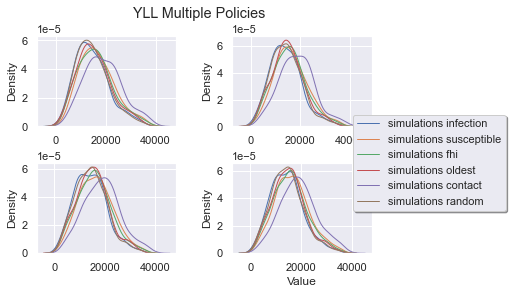

In [8]:
cut_offs = [20, 40, 100, 200]
print("Deaths")
print()
fig, axs = plt.subplots(2,2)
for i in range(len(cut_offs)):
    if i==0: j, k = 0,0
    elif i==1: j, k = 0,1
    elif i==2: j, k = 1,0
    elif i==3: j, k = 1,1
    for key in list(results.keys()): density_plot(objective_values[key][:cut_offs[i],0], axs[j,k])
plt.legend(loc='right', bbox_to_anchor=(2, 1),
        ncol=1, fancybox=True, shadow=True)
plt.suptitle('Fatalities Multiple Policies')
plt.xlabel('Value')
plt.ylabel('Density')
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()



cut_offs = [20, 40, 100, 200]
print("Infected")
print()
fig, axs = plt.subplots(2,2)
for i in range(len(cut_offs)):
    if i==0: j, k = 0,0
    elif i==1: j, k = 0,1
    elif i==2: j, k = 1,0
    elif i==3: j, k = 1,1
    for key in list(results.keys()): density_plot(objective_values[key][:cut_offs[i],1], axs[j,k])
plt.legend(loc='right', bbox_to_anchor=(2, 1),
        ncol=1, fancybox=True, shadow=True)
plt.suptitle('Infected Multiple Policies')
plt.xlabel('Value')
plt.ylabel('Density')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()


cut_offs = [100, 200, 300, 500]
print("YLL")
print()
fig, axs = plt.subplots(2,2)
for i in range(len(cut_offs)):
    if i==0: j, k = 0,0
    elif i==1: j, k = 0,1
    elif i==2: j, k = 1,0
    elif i==3: j, k = 1,1
    for key in list(results.keys()): density_plot(objective_values[key][:cut_offs[i],2], axs[j,k])
plt.legend(loc='right', bbox_to_anchor=(2, 1),
        ncol=1, fancybox=True, shadow=True)
plt.suptitle('YLL Multiple Policies')
plt.xlabel('Value')
plt.ylabel('Density')
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()



In [9]:
df = pd.read_csv('../data/waves/world_daily_cases.csv')
df[df.country == "Norway"].fillna(0)

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
63969,2020-2-15,Norway,0.0,0.0,0.0,0.0,0.0
63970,2020-2-16,Norway,0.0,0.0,0.0,0.0,0.0
63971,2020-2-17,Norway,0.0,0.0,0.0,0.0,0.0
63972,2020-2-18,Norway,0.0,0.0,0.0,0.0,0.0
63973,2020-2-19,Norway,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
64399,2021-4-20,Norway,108587.0,559.0,18926.0,709.0,0.0
64400,2021-4-21,Norway,109137.0,550.0,19451.0,734.0,25.0
64401,2021-4-22,Norway,109581.0,444.0,19894.0,735.0,1.0
64402,2021-4-23,Norway,110061.0,480.0,20373.0,736.0,1.0


## T-test of observations

In [10]:
def t_test(first, second):
        """ Performs one-sided t-test to check to variables for significant difference

        Args:
            first (Individual): presumed best individual
            second (Individual): presumed worse individual
            significance (float, optional): level of significance to test against. Defaults to 0.1.

        Returns:
            bool: True if significance is achieved
        """
        if not (first==second).all():
            z = first - second
            return scipy.stats.ttest_ind(z, np.zeros(len(first)), alternative="less").pvalue
        else:
            return 1

In [36]:
dead = dict(map(lambda x: (x[0], np.array(x[1])[:,0]), objective_values.items()))
infected = dict(map(lambda x: (x[0], np.array(x[1])[:,1]), objective_values.items()))
yll = dict(map(lambda x: (x[0], np.array(x[1])[:,2]), objective_values.items()))
vaccinated = dict(map(lambda x: (x[0], np.array(x[1])[:,3]), objective_values.items()))
weighted = dict(map(lambda x: (x[0], 0.01*np.array(x[1])[:,1] + np.array(x[1])[:,0]), objective_values.items()))
mean_dead = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,0])), objective_values.items()))
mean_infected = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,1])), objective_values.items()))
mean_yll = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,2])), objective_values.items()))
mean_vaccinated = dict(map(lambda x: (x[0], np.mean(np.array(x[1])[:,3])), objective_values.items()))
mean_weighted = dict(map(lambda x: (x[0], np.mean(0.01*np.array(x[1])[:,1] + np.array(x[1])[:,0])), objective_values.items()))
sorted_dead = dict(sorted(mean_dead.items(), key=lambda x: x[1]))
sorted_infected = dict(sorted(mean_infected.items(), key=lambda x: x[1]))
sorted_yll = dict(sorted(mean_yll.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_vaccinated.items(), key=lambda x: x[1]))
sorted_vaccinated = dict(sorted(mean_weighted.items(), key=lambda x: x[1]))
std_dead = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,0])), objective_values.items()))
std_infected = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,1])), objective_values.items()))
std_yll = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,2])), objective_values.items()))
std_vaccinated = dict(map(lambda x: (x[0], np.std(np.array(x[1])[:,3])), objective_values.items()))
std_weighted = dict(map(lambda x: (x[0], np.std(0.01*np.array(x[1])[:,1] + np.array(x[1])[:,0])), objective_values.items()))


In [37]:
mean_weighted

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 2204.7150526694813,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 2498.9533550906253,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 2404.9923118044608,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 2373.6381881601783,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 2773.6088658324065,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 2234.657890289986}

<AxesSubplot:ylabel='Density'>

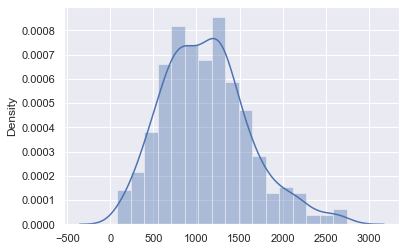

In [12]:
sns.distplot(objective_values['results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47'][:,0])

<AxesSubplot:ylabel='Density'>

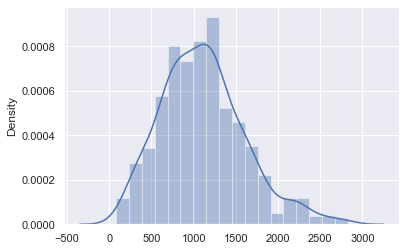

In [13]:
sns.distplot(objective_values['results/full_vaccines/500_simulations_random_2021_06_02_13_28_02'][:,0])

<AxesSubplot:ylabel='Density'>

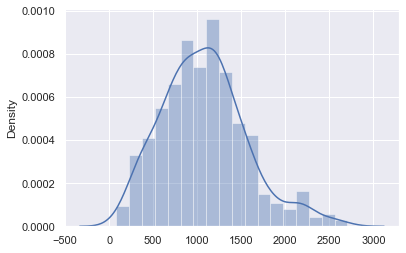

In [14]:
sns.distplot(objective_values['results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16'][:,0])

In [15]:
key = 'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47'
np.where(objective_values[key][:,3] < 1000000)

(array([ 25,  50, 107, 218, 272, 307, 359, 381, 449, 473]),)

In [16]:
key = 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02'
np.where(objective_values[key][:,3] < mean_vaccinated[key]-3*std_vaccinated[key])

(array([], dtype=int64),)

<AxesSubplot:ylabel='Density'>

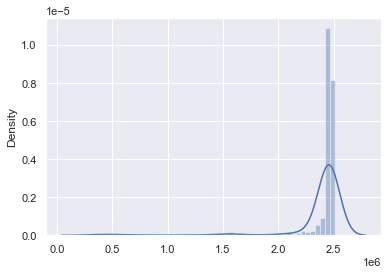

In [17]:
sns.distplot(objective_values['results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47'][:,3])

<AxesSubplot:ylabel='Density'>

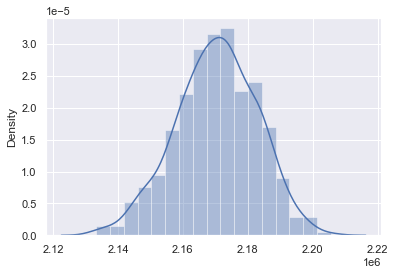

In [18]:
sns.distplot(objective_values['results/full_vaccines/500_simulations_random_2021_06_02_13_28_02'][:,3])

In [19]:
mean_vaccinated

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 2372560.008746731,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 2584097.0,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 2542391.684013028,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 2079865.1905644806,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 2471636.91,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 2170301.393999999}

In [20]:
std_vaccinated

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 325283.72815728013,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 1.2217731176769452e-09,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 21652.69770882668,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 44946.67557394813,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 40543.54132428377,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 12435.242360274358}

In [21]:
mean_infected

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 109311.58638535929,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 123095.2351779998,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 127795.32057145507,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 129730.6010625502,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 130377.68659386829,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 112505.91876223446}

In [22]:
std_infected

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 44440.321818509794,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 46921.40024061415,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 48177.678706622966,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 47522.33343287486,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 47347.08571336226,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 44486.38765342701}

In [23]:
mean_yll

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 14398.248,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 16440.824,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 15782.008,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 15121.852,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 18870.54,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 14536.374}

In [24]:
std_yll

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 6388.784547196438,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 6764.212548776391,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 6684.374374908694,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 6446.153535721594,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 7173.583879233587,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 6332.179601221368}

In [25]:
std_dead


{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 500.1068426750706,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 529.4749013076303,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 498.71681488830745,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 481.39518892494414,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 564.8394010393926,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 496.2948044577558}

In [26]:
mean_dead

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 1111.5991888158887,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 1268.0010033106273,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 1127.03910608991,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 1076.3321775346762,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 1469.8319998937236,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 1109.5987026676414}

Text(0, 0.5, 'Weighted value')

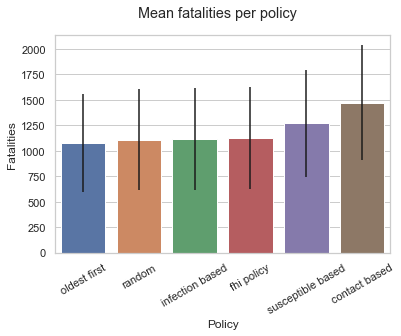

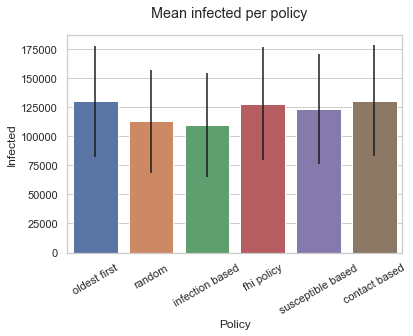

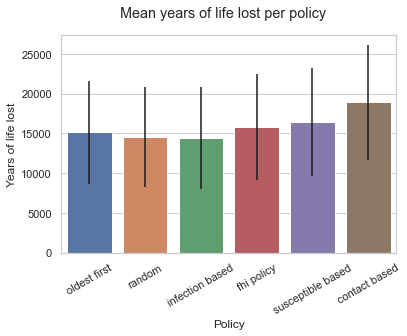

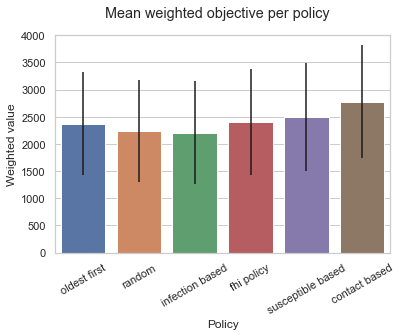

In [38]:
sns.set_theme(style="whitegrid")

plt.figure()
x=[]
y=[]
yerr=[]
for key in sorted_dead:
    x.append(key.split('_')[3] + ' ' + key.split('_')[4] if key.split('_')[3]!='random' else 'random')
    y.append(sorted_dead[key])
    yerr.append(std_dead[key])
sns.barplot(x=x, y=y, yerr=yerr)

plt.suptitle("Mean fatalities per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Fatalities")

plt.figure()
x=[]
y=[]
yerr=[]
for key in sorted_dead:
    x.append(key.split('_')[3] + ' ' + key.split('_')[4] if key.split('_')[3]!='random' else 'random')
    y.append(sorted_infected[key])
    yerr.append(std_infected[key])
sns.barplot(x=x, y=y, yerr=yerr)

plt.suptitle("Mean infected per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Infected")

plt.figure()
x=[]
y=[]
yerr=[]
for key in sorted_dead:
    x.append(key.split('_')[3] + ' ' + key.split('_')[4] if key.split('_')[3]!='random' else 'random')
    y.append(sorted_yll[key])
    yerr.append(std_yll[key])
sns.barplot(x=x, y=y, yerr=yerr)

plt.suptitle("Mean years of life lost per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Years of life lost")

plt.figure()
x=[]
y=[]
yerr=[]
for key in sorted_dead:
    x.append(key.split('_')[3] + ' ' + key.split('_')[4] if key.split('_')[3]!='random' else 'random')
    y.append(mean_weighted[key])
    yerr.append(std_weighted[key])
sns.barplot(x=x, y=y, yerr=yerr)

plt.suptitle("Mean weighted objective per policy")
plt.xticks(rotation=30)
plt.xlabel("Policy")
plt.ylabel("Weighted value")

Text(0, 0.5, 'Significance level')

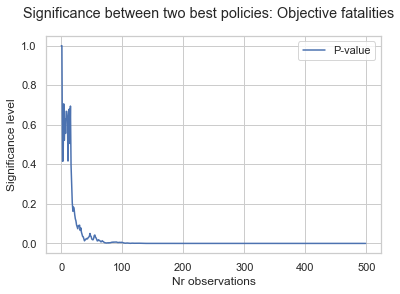

In [28]:
significance = 0.05
objective_value_best = objective_values[list(sorted_dead.keys())[0]][:,0]
objective_value_second_best = objective_values[list(sorted_dead.keys())[1]][:,0]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value")
plt.suptitle("Significance between two best policies: Objective fatalities")
plt.xlabel("Nr observations")
plt.ylabel("Significance level")





Text(0, 0.5, 'Significance level')

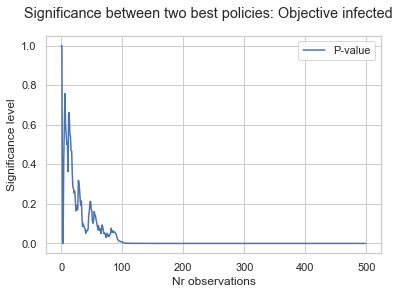

In [29]:
objective_value_best = objective_values[list(sorted_infected.keys())[0]][:,1]
objective_value_second_best = objective_values[list(sorted_infected.keys())[1]][:,1]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value")
plt.suptitle("Significance between two best policies: Objective infected")
plt.xlabel("Nr observations")
plt.ylabel("Significance level")

Text(0, 0.5, 'Significance level')

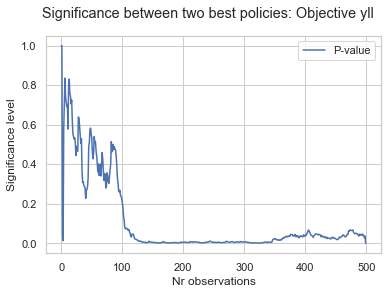

In [30]:
objective_value_best = objective_values[list(sorted_yll.keys())[0]][:,2]
objective_value_second_best = objective_values[list(sorted_yll.keys())[1]][:,2]
p_values = np.zeros(len(objective_value_best))
observations = np.arange(len(objective_value_best))
for i in range(len(objective_value_best)-1):
    p_values[i] = t_test(objective_value_best[:i], objective_value_second_best[:i])
p_values[np.isnan(p_values)] = 1

sns.set()
sns.set_style("whitegrid")
sns.lineplot(observations, p_values, label="P-value")
plt.suptitle("Significance between two best policies: Objective yll")
plt.xlabel("Nr observations")
plt.ylabel("Significance level")

In [31]:
mean_dead

{'results/full_vaccines/500_simulations_infection_based_2021_06_02_12_33_47': 1111.5991888158887,
 'results/full_vaccines/500_simulations_susceptible_based_2021_06_02_12_33_53': 1268.0010033106273,
 'results/full_vaccines/500_simulations_fhi_policy_2021_06_02_12_35_53': 1127.03910608991,
 'results/full_vaccines/500_simulations_oldest_first_2021_06_02_12_35_16': 1076.3321775346762,
 'results/full_vaccines/500_simulations_contact_based_2021_06_02_12_35_48': 1469.8319998937236,
 'results/full_vaccines/500_simulations_random_2021_06_02_13_28_02': 1109.5987026676414}